# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [1]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch

### Importing Required Libraries

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import lightgbm as lgb
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

### Variables

In [3]:
print_errors = False
build_new_dataset = False
model_type = 'LSTM' # 'LSTM', 'GBM' or 'MLP'
symbols = 'advanced' # 'simple' or 'advanced'. simple are the tickers from the screener notebook and advanced are all of the tickers in 'filtered_tickers'

## Data Preparation

In [4]:
if symbols == 'simple':
    symbols = pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()
if symbols == 'advanced':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['A', 'AA', 'AAT', ..., 'ZEUS', 'ZION', 'ZUMZ'], dtype=object)

#### Download annual financial data

In [5]:
if build_new_dataset:
    df = pd.DataFrame()
    for symbol in tqdm(symbols):
        try:
            ticker_df = pd.DataFrame()
            ticker = yf.Ticker(symbol)
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()

            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
        
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:
                        earning_date_data['1 Year Future Change'] = float(price_data.loc[earning_date + pd.Timedelta(days=day_offset+365,), ('Close', symbol)]) / float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        got_price = True
                    except Exception:
                        day_offset += -1
                
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'

                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]

                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]

                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            imputer = SimpleImputer()
            wanted_columns = ticker_df.columns.drop(['Ticker', 'Date', '1 Year Future Change', 'Sector', 'Industry'])
            for column in wanted_columns:
                if not ticker_df[column].isna().all():
                    ticker_df[column] = imputer.fit_transform(ticker_df[[column]])

            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

    wanted_columns = df.columns.drop(['Ticker', 'Date', '1 Year Future Change', 'Sector', 'Industry'])
    for column in wanted_columns:
        df[column] = imputer.fit_transform(df[[column]])
        scaler = StandardScaler()
        scaler.fit(df[[column]])
        df[column] = scaler.transform(df[[column]])

    le = LabelEncoder()
    for non_numeric_column in ['Sector', 'Industry']:
        df[non_numeric_column] = df[non_numeric_column].astype(str)
        le.fit(df[non_numeric_column])
        df[non_numeric_column] = le.transform(df[non_numeric_column])

    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [6]:
df

,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Restricted Common Stock,Net Income From Tax Loss Carryforward
0,AA,2023-12-31,0.103476,0,5,-0.022618,0.075749,0.059613,-0.061755,0.063339,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
1,AA,2022-12-31,-0.261057,0,5,-0.021928,0.053653,0.059634,-0.061787,0.063386,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
2,AA,2021-12-31,-0.226370,0,5,-0.021762,0.069120,0.059256,-0.061659,0.063468,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
3,AA,2020-12-31,1.590461,0,5,-0.022103,0.066174,0.059501,-0.061734,0.063398,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4,AAT,2023-12-31,0.202075,8,96,-0.022136,0.000000,0.059580,-0.061729,0.063749,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4950,ZBRA,2020-12-31,0.548669,9,25,-0.021838,0.063081,0.059557,-0.061634,0.063758,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4951,ZUMZ,2024-01-31,-0.050670,2,7,-0.022235,0.075749,0.059620,-0.061775,0.063807,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4952,ZUMZ,2023-01-31,-0.335269,2,7,-0.022253,0.071866,0.059627,-0.061782,0.063802,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4953,ZUMZ,2022-01-31,-0.425362,2,7,-0.022124,0.067185,0.059634,-0.061788,0.063811,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0


### Splitting and normalization

In [7]:
unique_tickers = df['Ticker'].unique()

np.random.seed(42) 
np.random.shuffle(unique_tickers)

test_size = int(0.2 * len(unique_tickers))

test_tickers = unique_tickers[:test_size]
train_tickers = unique_tickers[test_size:]

test_data = df[df['Ticker'].isin(test_tickers)]
train_data = df[df['Ticker'].isin(train_tickers)]

display(test_data)
display(train_data)

,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Restricted Common Stock,Net Income From Tax Loss Carryforward
38,ADC,2023-12-31,0.155705,8,103,-0.021884,0.075631,0.059310,-0.061375,1.396429e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
39,ADC,2022-12-31,-0.076704,8,103,-0.021910,0.075665,0.059307,-0.061440,1.396429e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
40,ADC,2021-12-31,0.036196,8,103,-0.022012,0.075669,0.059410,-0.061466,1.396429e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
41,ADC,2020-12-31,0.112780,8,103,-0.021936,0.075655,0.059342,-0.061427,1.396429e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
87,AFL,2023-12-31,0.286185,5,62,-0.019415,-0.048034,0.059634,-0.061735,1.396429e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942,YY,2020-12-31,-0.414332,1,68,-0.021928,0.071064,0.059595,-0.061748,6.368539e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4947,ZBRA,2023-12-31,0.413002,9,25,-0.022310,0.073451,0.059562,-0.061673,6.374574e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4948,ZBRA,2022-12-31,0.061352,9,25,-0.021865,0.042561,0.059562,-0.061453,6.375673e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4949,ZBRA,2021-12-31,-0.570891,9,25,-0.021338,0.073230,0.059545,-0.061776,6.377137e-02,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0


,Ticker,Date,1 Year Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Restricted Common Stock,Net Income From Tax Loss Carryforward
0,AA,2023-12-31,0.103476,0,5,-0.022618,0.075749,0.059613,-0.061755,0.063339,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
1,AA,2022-12-31,-0.261057,0,5,-0.021928,0.053653,0.059634,-0.061787,0.063386,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
2,AA,2021-12-31,-0.226370,0,5,-0.021762,0.069120,0.059256,-0.061659,0.063468,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
3,AA,2020-12-31,1.590461,0,5,-0.022103,0.066174,0.059501,-0.061734,0.063398,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4,AAT,2023-12-31,0.202075,8,96,-0.022136,0.000000,0.059580,-0.061729,0.063749,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946,Z,2020-12-31,-0.508089,1,68,-0.021856,0.051105,0.059101,-0.061369,0.063700,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4951,ZUMZ,2024-01-31,-0.050670,2,7,-0.022235,0.075749,0.059620,-0.061775,0.063807,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4952,ZUMZ,2023-01-31,-0.335269,2,7,-0.022253,0.071866,0.059627,-0.061782,0.063802,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4953,ZUMZ,2022-01-31,-0.425362,2,7,-0.022124,0.067185,0.059634,-0.061788,0.063811,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0


In [8]:
# LSTM TEST
feature_columns = [col for col in df.columns if col not in ['Ticker', 'Date', '1 Year Future Change']]

# Step 3: Define the window size for sequences
k = 3  # Number of time steps in each sequence

# Step 4: Preprocess data - create training sequences and targets
sequences = []
targets = []
grouped = df.groupby('Ticker')
for ticker, group in grouped:
    # Ensure data is sorted by 'Date'
    group = group.sort_values('Date')
    df_features = group[feature_columns].values  # Shape: [n_dates, num_features]
    df_target = group['1 Year Future Change'].values              # Shape: [n_dates]
    n_dates = len(group)
    # For training, use sequences where the target is known (exclude "Latest")
    for j in range(k-1, n_dates - 1):  # j ranges from k-1 to n_dates-2
        seq = df_features[j - k + 1 : j + 1]  # Sequence of k time steps
        target = df_target[j]                  # Target at the last time step
        sequences.append(torch.tensor(seq, dtype=torch.float32))
        targets.append(torch.tensor(target, dtype=torch.float32))

# Step 5: Create a custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences  # List of [k, num_features] tensors
        self.targets = targets      # List of scalar targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Step 6: Create DataLoader
train_dataset = TimeSeriesDataset(sequences, targets)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [9]:
X_train = train_data.drop(columns=['Ticker', 'Date', '1 Year Future Change'])
y_train = train_data['1 Year Future Change']
X_test = test_data.drop(columns=['Ticker', 'Date', '1 Year Future Change'])
y_test = test_data['1 Year Future Change']

display(X_train)
display(X_test)

,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,Effect Of Exchange Rate Changes,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Restricted Common Stock,Net Income From Tax Loss Carryforward
0,0,5,-0.022618,0.075749,0.059613,-0.061755,0.063339,-0.067375,-0.066042,-1.096640e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
1,0,5,-0.021928,0.053653,0.059634,-0.061787,0.063386,-0.067192,-0.065839,-1.102933e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
2,0,5,-0.021762,0.069120,0.059256,-0.061659,0.063468,-0.067000,-0.065981,-1.104258e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
3,0,5,-0.022103,0.066174,0.059501,-0.061734,0.063398,-0.067189,-0.065954,-1.101277e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4,8,96,-0.022136,0.000000,0.059580,-0.061729,0.063749,-0.067787,-0.066684,-1.579427e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946,1,68,-0.021856,0.051105,0.059101,-0.061369,0.063700,-0.066995,-0.065792,-1.579427e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4951,2,7,-0.022235,0.075749,0.059620,-0.061775,0.063807,-0.067782,-0.066666,-1.100310e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4952,2,7,-0.022253,0.071866,0.059627,-0.061782,0.063802,-0.067785,-0.066650,-1.100672e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4953,2,7,-0.022124,0.067185,0.059634,-0.061788,0.063811,-0.067769,-0.066670,-1.100556e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0


,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,Effect Of Exchange Rate Changes,...,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Restricted Common Stock,Net Income From Tax Loss Carryforward
38,8,103,-0.021884,0.075631,0.059310,-0.061375,1.396429e-17,-0.067816,-0.066693,-1.579427e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
39,8,103,-0.021910,0.075665,0.059307,-0.061440,1.396429e-17,-0.067810,-0.066686,-1.579427e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
40,8,103,-0.022012,0.075669,0.059410,-0.061466,1.396429e-17,-0.067803,-0.066703,-1.579427e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
41,8,103,-0.021936,0.075655,0.059342,-0.061427,1.396429e-17,-0.067810,-0.066694,-1.579427e-17,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
87,5,62,-0.019415,-0.048034,0.059634,-0.061735,1.396429e-17,-0.065981,-0.064930,-1.073785e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942,1,68,-0.021928,0.071064,0.059595,-0.061748,6.368539e-02,-0.067044,-0.066412,-1.091685e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4947,9,25,-0.022310,0.073451,0.059562,-0.061673,6.374574e-02,-0.067764,-0.066653,-1.099952e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4948,9,25,-0.021865,0.042561,0.059562,-0.061453,6.375673e-02,-0.067777,-0.066551,-1.099952e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0
4949,9,25,-0.021338,0.073230,0.059545,-0.061776,6.377137e-02,-0.067680,-0.066620,-1.099952e-01,...,0.0,0.0,-9.952863e-16,0.0,0.0,-1.216757e-15,0.0,0.0,0.0,0.0


## Model Training

In [ ]:
if model_type == 'MLP':
    model = MLPRegressor(
        solver='adam',
        batch_size="auto",
        learning_rate='adaptive',
        hidden_layer_sizes=(100, 100, 100),
        alpha=1e-4,
        random_state=42,
        tol=0.00001,
        max_iter=1000,
        n_iter_no_change=10,
        verbose=True,
        early_stopping=False,
        shuffle=False,
    )
    model.fit(X_train, y_train)

if model_type == 'GBM':
    feature_cols = df.columns.drop(['Ticker', 'Date', '1 Year Future Change'])
    train_data = lgb.Dataset(X_train, label=y_train, feature_name=feature_cols.tolist())
    test_data = lgb.Dataset(X_test, label=y_test, feature_name=feature_cols.tolist())

    iterations = 500
    param = {
        'objective': 'regression',  # Use 'binary' for classification or 'regression' for continuous targets
        'metric': ['l1', 'l2', 'rmse'],             # Root Mean Squared Error for regression
        'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
        'num_leaves': 52,           # Maximum number of leaves in one tree
        'learning_rate': 0.01,      # Step size shrinkage
        'n_estimators': 1000,
        'feature_fraction': 0.8,    # Fraction of features to use in each iteration
        'bagging_fraction': 0.8,    # Fraction of data to use in each iteration
        'bagging_freq': 5,          # Perform bagging every 5 iterations
        'max_depth': -1,            # No limit on tree depth
        'min_data_in_leaf': 20,     # Minimum number of data points in a leaf
        'lambda_l1': 0.1,           # L1 regularization
        'lambda_l2': 0.1,           # L2 regularization
        'random_state': 42          # Seed for reproducibility
    }

    model = lgb.train(param, train_data, iterations)

if model_type == 'LSTM':
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, output_size):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
        
        def forward(self, x):
            # Input x: [batch_size, k, input_size]
            out, _ = self.lstm(x)        # out: [batch_size, k, hidden_size]
            out = out[:, -1, :]          # Take the last time step: [batch_size, hidden_size]
            out = self.fc(out)           # [batch_size, output_size]
            return out

    num_features = len(feature_columns)
    model = LSTMModel(input_size=num_features, hidden_size=50, num_layers=2, output_size=1)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100
    for epoch in tqdm(range(num_epochs)):
        for seqs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(seqs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
    
    model.eval()
    with torch.no_grad():
        all_predictions = []
        all_targets = []
        for seqs, labels in train_loader:
            outputs = model(seqs)
            all_predictions.append(outputs.squeeze().cpu().numpy())
            all_targets.append(labels.cpu().numpy())
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)

    mae = mean_absolute_error(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")

100%|██████████| 100/100 [00:15<00:00,  6.62it/s]


MAE: 0.0824
MSE: 0.0157
R²: 0.9071


## Testing and benchmarking

In [11]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

AttributeError: 'LSTMModel' object has no attribute 'predict'

In [ ]:
print(f'Actual: {y_test.head(1)}')
print(f'Prediction: {model.predict(X_test.head(1))}')

Actual: 4871    0.704953
Name: 1 Year Future Change, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
Prediction: [[0.46335426]]


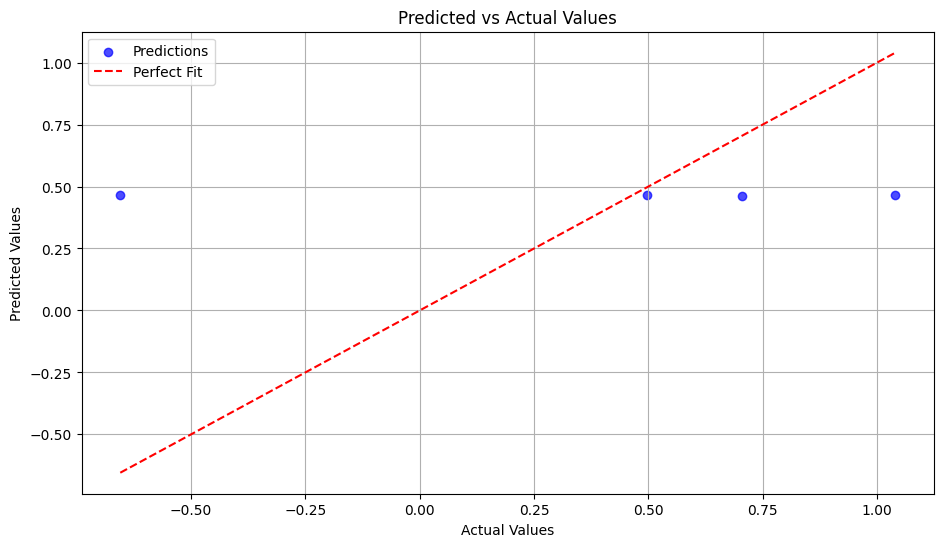

In [ ]:
plt.figure(figsize=(11, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Predictions